# Investigation of the use of matrixes in mini-batch stochastic gradient optimization

Importing libraries and defining basic functions.

In [1]:
import numpy as np
import random
import mnist_loader
import network

In [3]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

## Training using the normal network

In [5]:

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
net = network.Network([784,30,10])
net.SGD(training_data,5,16,3.0,test_data)

Epoch 0: 9010/10000
Epoch 1: 9200/10000
Epoch 2: 9287/10000
Epoch 3: 9331/10000
Epoch 4: 9362/10000


## Feedforward with network_matx

In [6]:
# Load data
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# Create Net
net = network.Network([784,30,10])

In [10]:
training_data = list(training_data)
n = len(training_data)
if test_data:
    test_data = list(test_data)
    n_test = len(test_data)

# Create mini-batch
random.shuffle(training_data)
mini_batch = training_data[0:3]
X = [x for x,y in mini_batch]
Y = [y for x,y in mini_batch]
print("X shape: {},{},{} | Y shape: {},{},{}".format(len(X),len(X[0]),len(X[0][0]),len(Y),len(Y[0]),len(Y[0][0])))

X shape: 3,784,1 | Y shape: 3,10,1


In [11]:
# Initiate
nabla_b = [np.zeros(b.shape) for b in net.biases]
nabla_w = [np.zeros(w.shape) for w in net.weights]
#TODO: print nabla shapes
print("weights shape: ({}x{}),({}x{}) | biases shape: ({}x{}),({}x{})".format(len(nabla_w[0]),len(nabla_w[0][0]),len(nabla_w[1]),len(nabla_w[1][0]),len(nabla_b[0]),len(nabla_b[0][0]),len(nabla_b[1]),len(nabla_b[1][0])))


weights shape: (30x784),(10x30) | biases shape: (30x1),(10x1)


In [12]:
# feedforward
activation = X # shape = (mini_batch_size, 784, 1) 
activations = [X] # list to store all activations, layer-by-layer
Zs = [] # list to store all z vectors, layer-by-layer
for b,w in zip(net.biases,net.weights):
    Z = np.transpose(np.dot(w, activation),(1,0,2)) + b
    Zs.append(Z)
    activation = sigmoid(Z)
    activations.append(activation)
    print("Shape of activation: {}".format(activation.shape))


Shape of activation: (3, 30, 1)
Shape of activation: (3, 10, 1)


Shape of nabla_b: ((10, 1))


## Figuring out the dimensions to get the weight vector
Don't run the cells below!!

In [9]:
# Figuring out the dimensions to get the weight vector
dum1 = np.transpose(delta,(2,1,0))
dum2 = np.transpose(activations[-2],(2,0,1))
prod = np.dot(dum1, dum2)
#nabla_w[-1] = np.dot(delta, activations[-2])
dum1.shape,dum2.shape,prod.shape,np.squeeze(prod).shape

((1, 10, 3), (1, 3, 30), (1, 10, 1, 30), (10, 30))

In [13]:
# check if the above code sums the 16 examples correctly
_dum1 = np.squeeze(np.transpose(delta,(2,1,0)))
_dum2 = np.squeeze(np.transpose(activations[-2],(2,0,1)))
_prod = np.dot(dum1, dum2)
_dum1.shape, _dum2.shape,_prod.shape

((10, 3), (3, 30), (1, 10, 1, 30))

In [ ]:
#Finding an easier way --> sum delta first (WRONG ACTUALLY)
delta = np.sum(net.cost_derivative(activations[-1],Y) * \
        sigmoid_prime(Zs[-1]),axis=0)
print("Shape of Delta: {}".format(delta.shape))

nabla_b[-1] = delta
nabla_w[-1] = np.dot(delta, np.sum(np.transpose(activations[-2],(0,2,1)),axis=0))
print("Shape of nabla_w: {}".format(nabla_w[-1].shape))
np.transpose(activations[-2],(0,2,1)).shape

Shape of Delta: (10, 1)
Shape of nabla_w: (10, 30)


(3, 1, 30)

In [12]:
np.sum(prod == _prod),np.sum(prod == nabla_w[-1])



(300, 0)

As you can observe above, using `np.sum` on `delta` above does not get the same matrix as using `np.sum` after the dot product in `nabla_w`. Imagine trying to multiply delta and activation as shown below:

delta --> Vector A (10x3): [
    [A0_1, A0_2, A0_3], 
    [A1_1, A1_2, A1_3], 
    [A2_1, A2_2, A2_3], 
            ...
    [A9_1, A9_2, A9_3]       
]

activation (30x3): [
    [B0_1, B0_2, B0_3],
    [B1_1, B1_2, B1_3],
    [B2_1, B2_2, B2_3],
            ...
    [B29_1, B29_2, B29_3]       
]

activation_transposed --> Vector B (3x30): [
    [B0_1, B1_1, B2_1 ... B29_1],
    [B0_2, B1_2, B2_2 ... B29_2],
    [B0_3, B1_3, B2_3 ... B29_3]
]

The desired dot product is shown (10x30): [
    [(A0_1*B0_1 + A0_2*B0_2 + A0_3*B0_3), (A0_1*B1_1 + A0_2*B1_2 + A0_3*B1_3) ... (A0_1*B29_1 + A0_2*B29_2 + A0_3*B29_3)],
    [(A1_1*B0_1 + A1_2*B0_2 + A1_3*B0_3), (A1_1*B1_1 + A1_2*B1_2 + A1_3*B1_3) ... (A1_1*B29_1 + A1_2*B29_2 + A1_3*B29_3),
                                                        ... ...
    [(A9_1*B0_1 + A9_2*B0_2 + A9_3*B0_3), (A9_1*B1_1 + A9_2*B1_2 + A9_3*B1_3) ... (A9_1*B29_1 + A9_2*B29_2 + A9_3*B29_3),
] 

if delta is summed before the dot product, the dot product will be as follows: [
    [(A0_1 + A0_2 + A0_3)(B0_1 + B0_2 + B0_3), (A0_1 + A0_2 + A0_3)(B1_1 + B1_2 + B1_3) ... (A0_1 + A0_2 + A0_3)(B29_1 + B29_2 + B29_3)],
    [(A1_1 + A1_2 + A1_3)(B0_1 + B0_2 + B0_3), (A1_1 + A1_2 + A1_3)(B1_1 + B1_2 + B1_3) ... (A1_1 + A1_2 + A1_3)(B29_1 + B29_2 + B29_3)],
                                                        ... ...
    [(A9_1 + A9_2 + A9_3)(B0_1 + B0_2 + B0_3), (A9_1 + A9_2 + A9_3)(B1_1 + B1_2 + B1_3) ... (A9_1 + A9_2 + A9_3)(B29_1 + B29_2 + B29_3)]
]

Thus, the sum of the `nabla_w` must only be taken after the dot product.

## Backward Pass

In [29]:
# Correct backward pass
print("Last layer")
delta_batch = net.cost_derivative(activations[-1],Y) * \
        sigmoid_prime(Zs[-1]) # shape = (mini_batch_size,10,1)
print("Shape of delta_batch: {}".format(delta_batch.shape))
nabla_b[-1] = np.sum(delta_batch, axis=0)
print("Shape of nabla_b: {}".format(nabla_b[-1].shape))
nabla_w[-1] = np.squeeze(np.dot(np.transpose(delta_batch,(2,1,0)),np.transpose(activations[-2],(2,0,1))))
print("Shape of nabla_w: {}".format(nabla_w[-1].shape))

# Subsequent backward pass
print("2nd last layer")
Z = Zs[-2]
sp = sigmoid_prime(Z)

delta_batch = np.transpose(np.dot(net.weights[-2+1].transpose(), delta_batch),(1,0,2)) * sp
print("Shape of delta_batch: {}".format(delta_batch.shape))
nabla_b[-2] = np.sum(delta_batch,axis=0)
print("Shape of nabla_b: {}".format(nabla_b[-2].shape))
nabla_w[-2] = np.squeeze(np.dot(np.transpose(delta_batch,(2,1,0)), np.transpose(activations[-2-1],(2,0,1))))
print("Shape of nabla_w: {}".format(nabla_w[-2].shape))
#net.weights[-1].shape,delta_batch.shape,sp.shape


Last layer
Shape of delta_batch: (3, 10, 1)
Shape of nabla_b: (10, 1)
Shape of nabla_w: (10, 30)
2nd last layer
Shape of delta_batch: (3, 30, 1)
Shape of nabla_b: (30, 1)
Shape of nabla_w: (30, 784)


## The Final Test

In [11]:
import numpy as np
import random
import mnist_loader
import network_matx

In [12]:
# Load data
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# Create Net
net = network_matx.Network([784,30,10])

In [13]:
net.SGD(training_data,5,16,3.0,test_data)

Epoch 0: 8979/10000
Epoch 1: 9224/10000
Epoch 2: 9297/10000
Epoch 3: 9343/10000
Epoch 4: 9347/10000


## The Comparison Time Test
Yay it works! Now to see if the matrix-based approach has actually made the network faster...

In [1]:
import numpy as np
import random
import mnist_loader
import network
import network_matx
import time

COUNT = 3
EPOCHS = 5


Without the matrix-based approach

In [2]:
time_diff = []
for i in range(COUNT):
    # Load data
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    # Create Net
    net = network.Network([784,30,10])
    tic = time.perf_counter()
    net.SGD(training_data,EPOCHS,16,3.0,test_data)
    toc = time.perf_counter()
    # Record time taken for one cycle
    time_diff.append(toc-tic)

#avg_times[str(b)] = np.average(time_diff)
print("Time taken for 5 epochs of SGD w/o matrix: {:0.4f}".format(np.average(time_diff)))


Epoch 0: 8197/10000
Epoch 1: 8331/10000
Epoch 2: 8416/10000
Epoch 3: 8469/10000
Epoch 4: 8502/10000
Epoch 0: 8980/10000
Epoch 1: 9136/10000
Epoch 2: 9203/10000
Epoch 3: 9278/10000
Epoch 4: 9281/10000
Epoch 0: 8979/10000
Epoch 1: 9168/10000
Epoch 2: 9185/10000
Epoch 3: 9343/10000
Epoch 4: 9347/10000
Time taken for 5 epochs of SGD w/o matrix: 12.0633


With Matrix-based approach

In [14]:
time_diff = []
for i in range(COUNT):
    # Load data
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    # Create Net
    net = network_matx.Network([784,30,10])
    tic = time.perf_counter()
    net.SGD(training_data,EPOCHS,16,3.0,test_data)
    toc = time.perf_counter()
    # Record time taken for one cycle
    time_diff.append(toc-tic)

#avg_times[str(b)] = np.average(time_diff)
print("Time taken for 5 epochs of SGD w/o matrix: {:0.4f}".format(np.average(time_diff)))

Epoch 0: 8976/10000
Epoch 1: 9152/10000
Epoch 2: 9240/10000
Epoch 3: 9254/10000
Epoch 4: 9311/10000
8.865893532998598
Epoch 0: 8886/10000
Epoch 1: 9156/10000
Epoch 2: 9233/10000
Epoch 3: 9331/10000
Epoch 4: 9395/10000
8.823941388000094
Epoch 0: 7124/10000
Epoch 1: 7259/10000
Epoch 2: 7328/10000
Epoch 3: 9250/10000
Epoch 4: 9309/10000
8.894066030999966
Time taken for 5 epochs of SGD w/ matrix: 8.8613


As shown above, for 5 epochs, SGD, using the matrix-based approach for each mini-batch, is 12.1394 - 8.8613 = 3.2781, which is approximately a 27% decrease in time taken. This is a significant increase in speed for SGD.

The following test will use different number of epochs to observe the  change in difference in time taken between the network w/o matrix based approach against the network w/ matrix based approach

In [5]:
import numpy as np
import random
import mnist_loader
import network
import network_matx
import time
import matplotlib.pyplot as plt
import collections

COUNT = 5
EPOCHS = 10
batch_sizes = [1,2,4,8,16,32,64,128,256,512,1024]

In [3]:
def avg_time(e:int, b:int) -> int:
    """
    Function to load data, create network, do SGD, and return time taken per epoch
    Parameters:
    -----------
    e = number of epochs
    b = batch size
    """
    time_diff = []
    for i in range(COUNT):
        # Load data
        training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
        # Create Net
        net = network.Network([784,30,10])
        tic = time.perf_counter()
        net.SGD(training_data,e,b,3.0,test_data)
        toc = time.perf_counter()
        # Record time taken for one cycle
        time_diff.append(toc-tic)

    return np.average(time_diff)/EPOCHS

In [4]:
def avg_time_matx(e:int, b:int) -> int:
    """
    Function to load data, create network, do SGD, and return time taken per epoch
    Parameters:
    -----------
    e = number of epochs
    b = batch size
    """
    time_diff = []
    for i in range(COUNT):
        # Load data
        training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
        # Create Net
        net = network_matx.Network([784,30,10])
        tic = time.perf_counter()
        net.SGD(training_data,e,b,3.0,test_data)
        toc = time.perf_counter()
        # Record time taken for one cycle
        time_diff.append(toc-tic)

    return np.average(time_diff)/EPOCHS

In [5]:
avg_times = {}
for b in batch_sizes:
    avg_times[b] = avg_time(EPOCHS,b)


Epoch 0: 8097/10000
Epoch 1: 8484/10000
Epoch 2: 8623/10000
Epoch 3: 8742/10000
Epoch 4: 8550/10000
Epoch 5: 8119/10000
Epoch 6: 8484/10000
Epoch 7: 8527/10000
Epoch 8: 8941/10000
Epoch 9: 8589/10000
Epoch 0: 6993/10000
Epoch 1: 8167/10000
Epoch 2: 8179/10000
Epoch 3: 8478/10000
Epoch 4: 8276/10000
Epoch 5: 8689/10000
Epoch 6: 8730/10000
Epoch 7: 8509/10000
Epoch 8: 8739/10000
Epoch 9: 8610/10000
Epoch 0: 7699/10000
Epoch 1: 8504/10000
Epoch 2: 8380/10000
Epoch 3: 8322/10000
Epoch 4: 8561/10000
Epoch 5: 8764/10000
Epoch 6: 8584/10000
Epoch 7: 8641/10000
Epoch 8: 8644/10000
Epoch 9: 8661/10000
Epoch 0: 6844/10000
Epoch 1: 7062/10000
Epoch 2: 7432/10000
Epoch 3: 7499/10000
Epoch 4: 7753/10000
Epoch 5: 6912/10000
Epoch 6: 7745/10000
Epoch 7: 7647/10000
Epoch 8: 7715/10000
Epoch 9: 7975/10000
Epoch 0: 8140/10000
Epoch 1: 8144/10000
Epoch 2: 8360/10000
Epoch 3: 8200/10000
Epoch 4: 8476/10000
Epoch 5: 8625/10000
Epoch 6: 8537/10000
Epoch 7: 8614/10000
Epoch 8: 8480/10000
Epoch 9: 8763/10000


In [6]:
#print(avg_times)
avg_times = dict(sorted(avg_times.items()))
d_avg_times = collections.OrderedDict(sorted(avg_times.items()))
d_avg_times

OrderedDict([(1, 3.4581496921799952),
             (2, 2.8352817529999994),
             (4, 2.5342207325800152),
             (8, 2.414314760999969),
             (16, 2.3168701213999885),
             (32, 2.2835648892800053),
             (64, 2.263847129039987),
             (128, 2.274801842600009),
             (256, 2.2828283028800067),
             (512, 2.4029902633200075),
             (1024, 2.3542784046200174)])

In [7]:
avg_times_matx = {}
for b in batch_sizes:
    avg_times_matx[b] = avg_time_matx(EPOCHS,b)

Epoch 0: 7432/10000
Epoch 1: 7421/10000
Epoch 2: 7368/10000
Epoch 3: 7456/10000
Epoch 4: 7481/10000
Epoch 5: 7679/10000
Epoch 6: 8048/10000
Epoch 7: 7877/10000
Epoch 8: 8129/10000
Epoch 9: 7762/10000
Epoch 0: 8438/10000
Epoch 1: 8315/10000
Epoch 2: 8597/10000
Epoch 3: 8621/10000
Epoch 4: 8416/10000
Epoch 5: 8565/10000
Epoch 6: 8574/10000
Epoch 7: 8519/10000
Epoch 8: 8804/10000
Epoch 9: 8811/10000
Epoch 0: 6924/10000
Epoch 1: 6694/10000
Epoch 2: 7162/10000
Epoch 3: 7435/10000
Epoch 4: 7669/10000
Epoch 5: 7701/10000
Epoch 6: 7890/10000
Epoch 7: 7452/10000
Epoch 8: 7422/10000
Epoch 9: 7650/10000
Epoch 0: 7948/10000
Epoch 1: 7383/10000
Epoch 2: 8197/10000
Epoch 3: 7931/10000
Epoch 4: 8294/10000
Epoch 5: 8259/10000
Epoch 6: 8622/10000
Epoch 7: 8611/10000
Epoch 8: 8587/10000
Epoch 9: 8362/10000
Epoch 0: 8106/10000
Epoch 1: 8408/10000
Epoch 2: 8109/10000
Epoch 3: 8648/10000
Epoch 4: 8734/10000
Epoch 5: 8529/10000
Epoch 6: 8330/10000
Epoch 7: 8799/10000
Epoch 8: 8841/10000
Epoch 9: 8755/10000


In [8]:
avg_times_matx = dict(sorted(avg_times_matx.items()))
d_avg_times_matx = collections.OrderedDict(sorted(avg_times_matx.items()))
d_avg_times_matx

OrderedDict([(1, 18.392763637200005),
             (2, 9.56161440404001),
             (4, 5.473375493099975),
             (8, 3.068831959739982),
             (16, 1.938976318219975),
             (32, 1.378448394640036),
             (64, 1.142724443119987),
             (128, 1.109391323100026),
             (256, 1.0941676863400063),
             (512, 1.29767382455997),
             (1024, 1.3365285761600172)])

## Storing the results

In [9]:
import pickle

#hi = {1:0, 2:1, 3:6}
#me = "hi"
# Saving the objects:
with open('results/data_dict.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([d_avg_times, d_avg_times_matx], f)



In [1]:
import pickle
# Getting back the objects:
with open('results/data_dict.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    loaded_for, loaded_matx = pickle.load(f)

loaded_for, loaded_matx

(OrderedDict([(1, 3.4581496921799952),
              (2, 2.8352817529999994),
              (4, 2.5342207325800152),
              (8, 2.414314760999969),
              (16, 2.3168701213999885),
              (32, 2.2835648892800053),
              (64, 2.263847129039987),
              (128, 2.274801842600009),
              (256, 2.2828283028800067),
              (512, 2.4029902633200075),
              (1024, 2.3542784046200174)]),
 OrderedDict([(1, 18.392763637200005),
              (2, 9.56161440404001),
              (4, 5.473375493099975),
              (8, 3.068831959739982),
              (16, 1.938976318219975),
              (32, 1.378448394640036),
              (64, 1.142724443119987),
              (128, 1.109391323100026),
              (256, 1.0941676863400063),
              (512, 1.29767382455997),
              (1024, 1.3365285761600172)]))

## Plotting the results

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df = pd.DataFrame([dict(loaded_for), dict(loaded_matx)], index=["for_loop_minibatch", "matrixed_minibatch"])
df = df.T
df["time_difference"] = df["for_loop_minibatch"] - df["matrixed_minibatch"]
df["speed_increase"] = df["time_difference"] / df["for_loop_minibatch"] *100
df

,for_loop_minibatch,matrixed_minibatch,time_difference,speed_increase
1,3.458150,18.392764,-14.934614,-431.867191
2,2.835282,9.561614,-6.726333,-237.236833
4,2.534221,5.473375,-2.939155,-115.978641
8,2.414315,3.068832,-0.654517,-27.109854
16,2.316870,1.938976,0.377894,16.310530
32,2.283565,1.378448,0.905116,39.636119
64,2.263847,1.142724,1.121123,49.522897
128,2.274802,1.109391,1.165411,51.231298
256,2.282828,1.094168,1.188661,52.069646
512,2.402990,1.297674,1.105316,45.997541


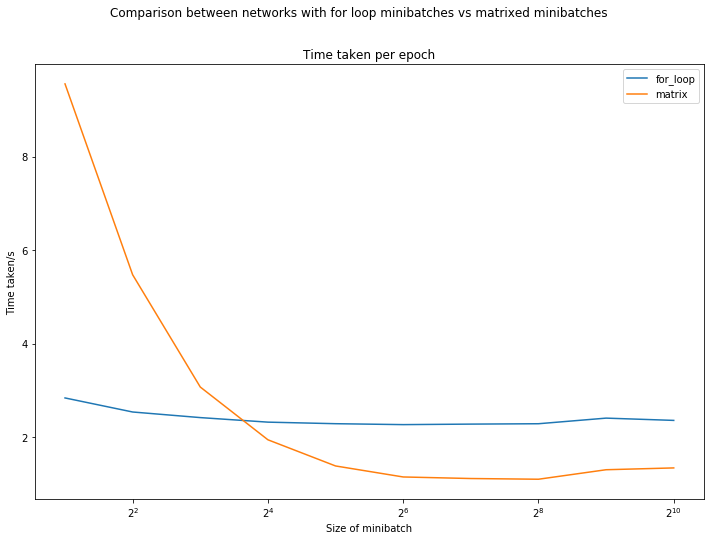

In [23]:
fig, axes = plt.subplots(figsize=(12,8))
fig.suptitle("Comparison between networks using For Loop Minibatches vs Matrixed Minibatches")
axes.plot(df["for_loop_minibatch"][1:],label="for_loop")
axes.plot(df["matrixed_minibatch"][1:],label="matrix")
axes.set_title("Time taken per epoch")
axes.set_xscale("log",basex=2)
axes.set_xlabel("Size of minibatch")
axes.set_ylabel("Time taken/s")
axes.legend()


Text(0, 0.5, 'Percentage of time difference')

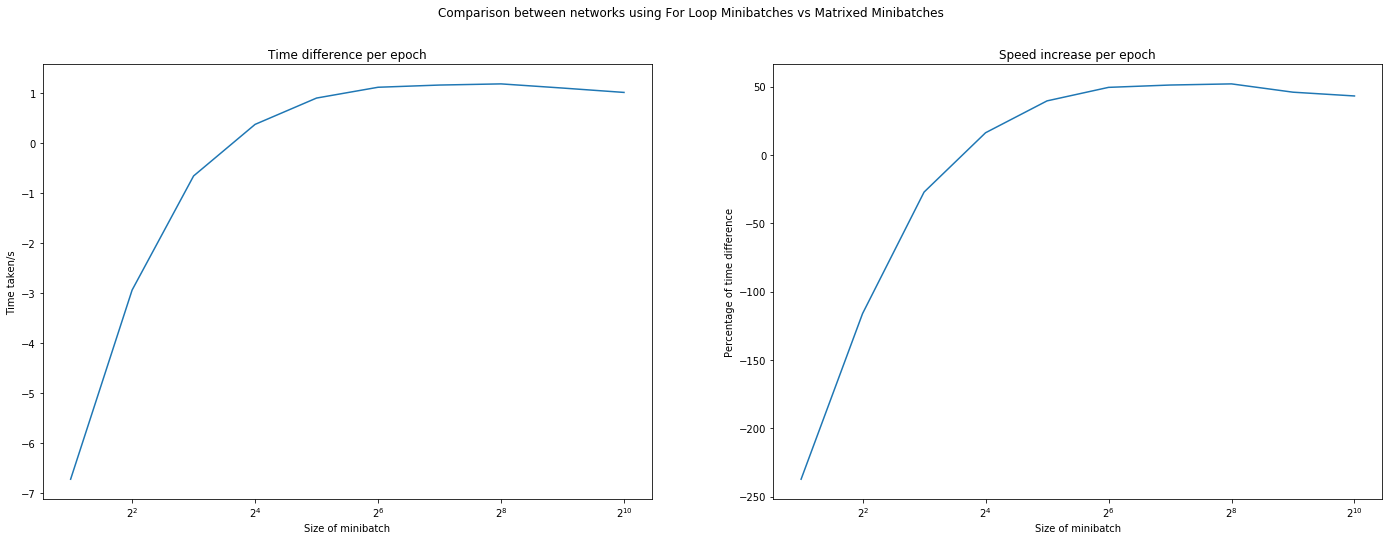

In [27]:
fig, axes = plt.subplots(1,2,figsize=(24,8))
fig.suptitle("Comparison between networks using For Loop Minibatches vs Matrixed Minibatches")
axes[0].plot(df["time_difference"][1:])
axes[0].set_title("Time difference per epoch")
axes[0].set_xscale("log",basex=2)
axes[0].set_xlabel("Size of minibatch")
axes[0].set_ylabel("Time taken/s")

axes[1].plot(df["speed_increase"][1:])
axes[1].set_title("Speed increase per epoch")
axes[1].set_xscale("log",basex=2)
axes[1].set_xlabel("Size of minibatch")
axes[1].set_ylabel("Percentage of time difference")

## Interpreting the results

In [7]:
import csv
import numpy as np

In [8]:
# Determining average performance of neural network for each mini-batch size
last_epoch_acc = []
with open('results/epoch_perf_for.csv') as csv_file:
    epoch_perf_for = csv.reader(csv_file, delimiter=',')
    for row in epoch_perf_for:
        for epoch in row:
            if epoch[:7] == 'Epoch 9': 
                last_epoch_acc.append(int(epoch[9:13])/100)

COUNT = 5 # defined earlier
avg_perf_for = []
for i in np.arange(0,len(last_epoch_acc),COUNT):
    avg_perf_for.append(np.average(last_epoch_acc[i:i+COUNT]))
avg_perf_for


[85.196,
 92.34200000000001,
 93.922,
 94.50200000000001,
 94.08800000000001,
 93.518,
 90.77000000000001,
 87.588,
 80.756,
 80.012,
 68.03]

In [9]:
# for matx
last_epoch_acc = []
with open('results/epoch_perf_matx.csv') as csv_file:
    epoch_perf_matx = csv.reader(csv_file, delimiter=',')
    for row in epoch_perf_matx:
        for epoch in row:
            if epoch[:7] == 'Epoch 9': 
                last_epoch_acc.append(int(epoch[9:13])/100)

COUNT = 5 # defined earlier
avg_perf_matx = []
for i in np.arange(0,len(last_epoch_acc),COUNT):
    avg_perf_matx.append(np.average(last_epoch_acc[i:i+COUNT]))
avg_perf_matx


[82.68,
 92.526,
 92.35799999999999,
 94.24,
 92.54400000000001,
 93.41600000000001,
 90.628,
 85.84200000000001,
 80.636,
 76.804,
 61.148]

In [10]:
df["for_perf"] = avg_perf_for
df["matrixed_perf"] = avg_perf_matx
df

,for_loop_minibatch,matrixed_minibatch,time_difference,speed_increase,for_perf,matrixed_perf
1,3.458150,18.392764,-14.934614,-431.867191,85.196,82.680
2,2.835282,9.561614,-6.726333,-237.236833,92.342,92.526
4,2.534221,5.473375,-2.939155,-115.978641,93.922,92.358
8,2.414315,3.068832,-0.654517,-27.109854,94.502,94.240
16,2.316870,1.938976,0.377894,16.310530,94.088,92.544
32,2.283565,1.378448,0.905116,39.636119,93.518,93.416
64,2.263847,1.142724,1.121123,49.522897,90.770,90.628
128,2.274802,1.109391,1.165411,51.231298,87.588,85.842
256,2.282828,1.094168,1.188661,52.069646,80.756,80.636
512,2.402990,1.297674,1.105316,45.997541,80.012,76.804


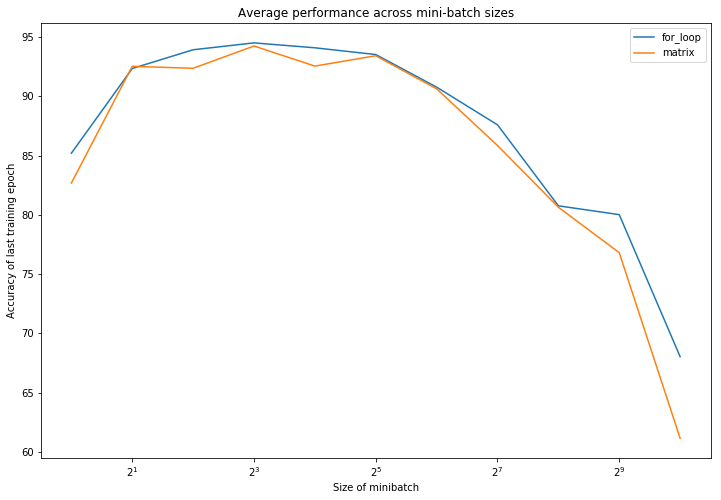

In [28]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_title("Average performance across mini-batch sizes")
ax.set_xscale("log",basex=2)
ax.plot(df["for_perf"], label="for_loop")
ax.plot(df["matrixed_perf"], label="matrix")

ax.set_xlabel("Size of minibatch")
ax.set_ylabel("Accuracy of last training epoch")
ax.legend()